In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import jax
import functools

In [11]:
def sample_seq(rng: jax.random.PRNGKey, seq_len: int, vocab_size: int):
    """
    Samples a sequence of integers, where each consequtive element is
    within a distance of 1 from the previous element.
    """
    _rng, rng = jax.random.split(rng)
    first_element = jax.random.randint(_rng, (1,), 0, vocab_size)[0]

    def _next_element(item, _):
        rng, prev_element = item
        rng, _rng = jax.random.split(rng)
        next_val = jax.random.randint(_rng, (1,), prev_element - 1, prev_element + 2)[0]
        next_val = jnp.clip(next_val, 0, vocab_size - 1)
        return (rng, next_val), next_val

    rng, seq = jax.lax.scan(_next_element, (rng, first_element), None, seq_len - 1)
    integer_seq = jnp.concatenate([first_element[jnp.newaxis], seq])
    return jax.nn.one_hot(integer_seq, vocab_size)


def sample_seq_batch(rng: jax.random.PRNGKey, seq_len: int, vocab_size: int, batch_size: int):
    sample_fn = functools.partial(sample_seq, seq_len=seq_len, vocab_size=vocab_size)
    return jax.vmap(sample_fn)(jax.random.split(rng, batch_size))

In [12]:
sample_seq(jax.random.PRNGKey(2), 5, 3)

Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [13]:
sample_seq_batch(jax.random.PRNGKey(2), 5, 3, 2)

Array([[[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]], dtype=float32)

In [69]:
class ScannedRNN(nn.Module):
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        new_carry, y = nn.GRUCell(features=self.hidden_size)(carry, x)
        return new_carry, y

    @staticmethod
    def initialize_carry(batch_size, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (batch_size, hidden_size))


class SeqEncoder(nn.Module):
    hidden_size: int = 128

    # @functools.partial(
    #     nn.scan,
    #     variable_broadcast="params",
    #     in_axes=0,
    #     out_axes=0,
    #     split_rngs={"params": False},
    # )
    @nn.compact
    def __call__(self, x):
        """Applies the module."""
        x = nn.Dense(features=self.hidden_size)(x)
        x = nn.relu(x)

        batch_size, *_ = x.shape
        carry = ScannedRNN.initialize_carry(batch_size, self.hidden_size)

        # swap batch and sequence axes
        x = jnp.transpose(x, (1, 0, 2))
        # apply rnn
        _, h = ScannedRNN(hidden_size=self.hidden_size)(carry, x)
        # swap back
        embs = jnp.transpose(h, (1, 0, 2))
        y = embs[:, -1]
        return y


In [70]:
VOCAB_SIZE = 5
SEQ_LEN = 16
BATCH_SIZE = 64


seq_encoder = SeqEncoder()
batch = sample_seq_batch(jax.random.PRNGKey(0), SEQ_LEN, VOCAB_SIZE, BATCH_SIZE)
seq_encoder_vars = seq_encoder.init(jax.random.PRNGKey(0), batch)
h = seq_encoder.apply(seq_encoder_vars, batch)
h.shape

(64, 128)

In [71]:
class DensityModel(nn.Module):
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs):
        x, sigmas = inputs
        x = SeqEncoder(hidden_size=self.hidden_size)(x)
        x = jnp.concatenate([x, sigmas], axis=-1)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.relu(x)
        y = nn.Dense(1)(x)
        return y.squeeze()


batch_size = 128
num_steps = 20000



NUM_NOISE_SCALES = 10
NOISE_SCALES = [0.63096**scale_index for scale_index in range(NUM_NOISE_SCALES)][::-1]
FULL_NOISE_SCALES = np.array([0] + NOISE_SCALES)
JNP_NOISE_SCALES = jnp.array(NOISE_SCALES)
JNP_FULL_NOISE_SCALES = jnp.array(FULL_NOISE_SCALES)
# JNP_DATA = jnp.array(data)
# N_DATA_SAMPLES = len(data)


def sample_batch(rng):
    rng, _rng = jax.random.split(rng)
    data = sample_seq_batch(_rng, SEQ_LEN, VOCAB_SIZE, batch_size)
    rng, _rng = jax.random.split(rng)
    noise_levels = jax.random.randint(_rng, (batch_size // 2,), 0, NUM_NOISE_SCALES)

    _, seq_len, vocab_size = data.shape
    pre_sigmas = JNP_FULL_NOISE_SCALES[noise_levels]
    post_sigmas = JNP_FULL_NOISE_SCALES[noise_levels + 1]

    rng, _rng = jax.random.split(rng)
    data_idx_pre = jax.random.choice(_rng, batch_size, (batch_size // 2,))
    data_batch_pre = data[data_idx_pre]

    rng, _rng = jax.random.split(rng)
    data_idx_post = jax.random.choice(_rng, batch_size, (batch_size // 2,))
    data_batch_post = data[data_idx_post]

    rng, _rng = jax.random.split(rng)
    pre_sigmas_rep = pre_sigmas[:, None].repeat(seq_len, axis=1)
    pre_sigmas_rep = pre_sigmas_rep[:, :, None].repeat(vocab_size, axis=2)
    pre_data = data_batch_pre + pre_sigmas_rep * jax.random.normal(_rng, data_batch_pre.shape)
    # post_data = data_batch_post + np.random.normal(0, post_sigmas[:, None], data_batch_post.shape)
    rng, _rng = jax.random.split(rng)
    post_sigmas_rep = post_sigmas[:, None].repeat(seq_len, axis=1)
    post_sigmas_rep = post_sigmas_rep[:, :, None].repeat(vocab_size, axis=2)
    post_data = data_batch_post + post_sigmas_rep * jax.random.normal(_rng, data_batch_post.shape)

    data_batch = jnp.concatenate([pre_data, post_data], axis=0)
    sigmas = jnp.concatenate([post_sigmas, post_sigmas], axis=0)
    return jnp.array(data_batch), jnp.array(sigmas)[:, np.newaxis]

In [72]:
data_batch, sigmas = sample_batch(jax.random.PRNGKey(0))
data_batch.shape, sigmas.shape

((128, 16, 5), (128, 1))

In [73]:
from flax.training.train_state import TrainState
import optax
import chex


def loss_fn(ratios: chex.Array):
    ratios_p = ratios[:batch_size // 2]
    ratios_q = ratios[batch_size // 2:]
    return (
        jnp.mean(-jnp.log(ratios_p / (ratios_p + 1)) 
                 - jnp.log(1 / (ratios_q + 1)))
    )


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, inputs):
        ratios = jnp.exp(train_state.apply_fn(params, inputs))
        return loss_fn(ratios)

    rng, _rng = jax.random.split(rng)
    inputs = sample_batch(_rng)
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, inputs)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs = sample_batch(_rng)
density_model = DensityModel()
init_params = density_model.init(_rng, inputs)
optimizer = optax.adam(1e-3)
train_state = TrainState.create(
    apply_fn=density_model.apply,
    params=init_params,
    tx=optimizer
)

(train_state, _), metrics = jax.lax.scan(
    update_fn, (train_state, rng), None, length=num_steps
)

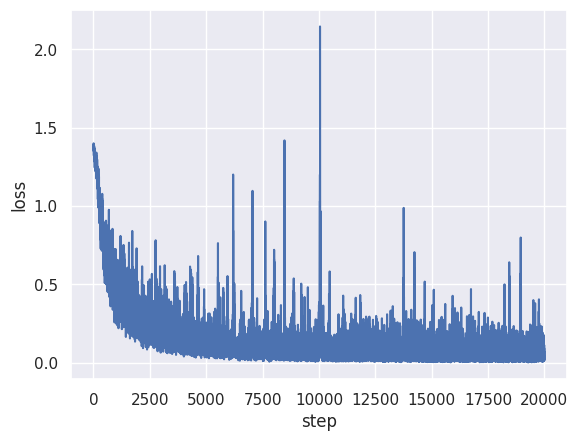

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': np.arange(metrics['loss'].size)
})

sns.lineplot(df, x='step', y='loss')
plt.show()

In [88]:
real_seqs.shape

(512, 16, 5)

In [105]:
def diffusion_pdf(x):
    sigmas = FULL_NOISE_SCALES[1:]
    x = jnp.array([x for _ in sigmas])
    sigmas = jnp.array(sigmas)[:, np.newaxis]
    inputs = (x, sigmas)
    # return jnp.exp(jnp.sum(density_model.apply(train_state.params, inputs)))
    return jnp.sum(density_model.apply(train_state.params, inputs))


real_seqs = sample_seq_batch(jax.random.PRNGKey(0), SEQ_LEN, VOCAB_SIZE, 512)

fake_seqs = jax.random.randint(jax.random.PRNGKey(0), (512, SEQ_LEN), 0, VOCAB_SIZE)
fake_seqs = jax.nn.one_hot(fake_seqs, VOCAB_SIZE)

noisy_fake_seqs = jax.random.normal(jax.random.PRNGKey(0), fake_seqs.shape) + 0.5

real_probs = jax.vmap(diffusion_pdf)(real_seqs)
fake_probs = jax.vmap(diffusion_pdf)(fake_seqs)
noisy_fake_probs = jax.vmap(diffusion_pdf)(noisy_fake_seqs)

df = pd.DataFrame({
    'prob': jnp.concatenate([real_probs, fake_probs, noisy_fake_probs]),
    'kind': ['real'] * real_probs.size + ['fake'] * fake_probs.size + ['noisy_fake'] * noisy_fake_probs.size
})

<Axes: xlabel='prob', ylabel='Count'>

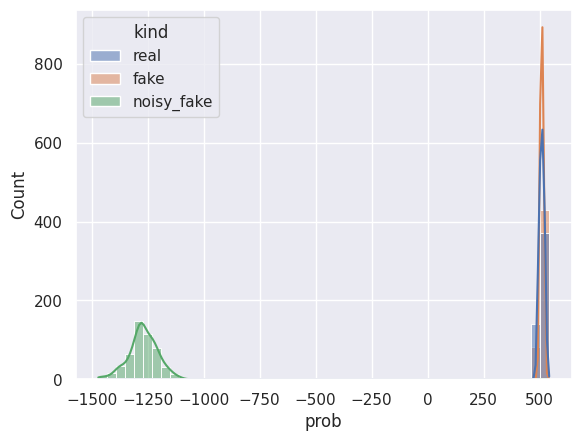

In [106]:
sns.histplot(df, x='prob', hue='kind', bins=50, kde=True)

## Using the Density Model for Generation

In [128]:
from flax.training.train_state import TrainState
import optax
import chex
import numpy as np


class GeneratorModel(nn.Module):
    hidden_size: int = 128
    output_shape: tuple = (16, 5)

    @nn.compact
    def __call__(self, latents, train: bool = False):
        x = nn.Dense(self.hidden_size)(latents)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        y = nn.Dense(np.prod(self.output_shape))(x)
        y = y.reshape((-1,) + self.output_shape)
        y = nn.softmax(y)

        return y.squeeze()

In [110]:
@jax.vmap
def diffusion_pdf_loss(x):
    sigmas = FULL_NOISE_SCALES[1:]
    x = jnp.array([x for _ in sigmas])
    sigmas = jnp.array(sigmas)[:, np.newaxis]
    inputs = (x, sigmas)
    return -jnp.sum(density_model.apply(train_state.params, inputs))


latent_dim = 64

def generator_sample(rng, batch_size=512):
    latents = jax.random.normal(rng, (batch_size, latent_dim))
    return latents


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, inputs):
        generated_x, updates = train_state.apply_fn(
            params, inputs, train=True,
            mutable=['batch_stats']
        )
        return diffusion_pdf_loss(generated_x).mean(), updates['batch_stats']

    rng, _rng = jax.random.split(rng)
    inputs = generator_sample(_rng)
    grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
    (loss, batch_stats), grads = grad_fn(train_state.params, inputs)
    updates, new_opt_state = train_state.tx.update(grads, train_state.opt_state)
    new_params = optax.apply_updates(train_state.params['params'], updates['params'])
    new_variables = {'params': new_params, 'batch_stats': batch_stats}
    new_train_state = train_state.replace(
        params=new_variables,
        opt_state=new_opt_state,
        step=train_state.step + 1
    )
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs = generator_sample(_rng)
generator = GeneratorModel()
init_params = generator.init(_rng, inputs)
optimizer = optax.adam(1e-3)
init_train_state = TrainState.create(
    apply_fn=generator.apply,
    params=init_params,
    tx=optimizer
)

(gen_train_state, _), gen_metrics = jax.lax.scan(
    update_fn, (init_train_state, rng), None, length=20000
)

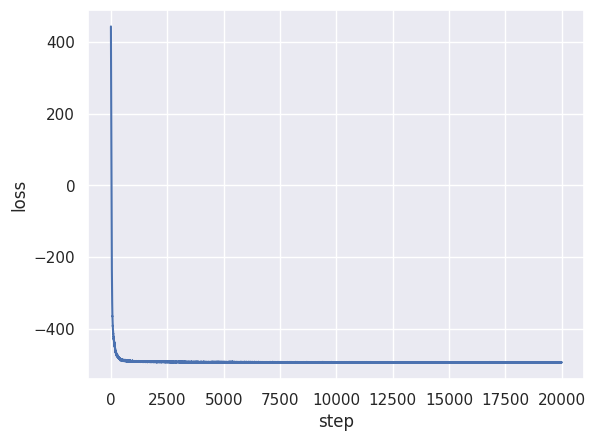

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': gen_metrics['loss'],
    'step': np.arange(gen_metrics['loss'].size)
})

sns.lineplot(df, x='step', y='loss')
plt.show()

In [112]:
inputs = generator_sample(_rng)
generated_x = gen_train_state.apply_fn(gen_train_state.params, inputs)
loss = diffusion_pdf_loss(generated_x).mean()
loss

Array(-494.55023, dtype=float32)

# The generator has collapsed to a mode

In [124]:
generated_x[:5].argmax(-1)

Array([[0, 2, 0, 3, 4, 4, 0, 0, 4, 3, 3, 0, 0, 0, 4, 4],
       [0, 2, 0, 3, 4, 4, 0, 0, 4, 3, 3, 0, 0, 0, 4, 4],
       [0, 2, 0, 3, 4, 4, 4, 0, 4, 3, 3, 0, 0, 0, 4, 0],
       [0, 2, 0, 3, 4, 4, 0, 0, 4, 3, 3, 0, 0, 0, 4, 4],
       [0, 2, 0, 3, 4, 4, 4, 0, 4, 3, 3, 0, 0, 0, 4, 0]], dtype=int32)

In [127]:
real_seq = sample_seq_batch(jax.random.PRNGKey(0), SEQ_LEN, VOCAB_SIZE, 5)
real_seq.argmax(-1)

Array([[1, 1, 2, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 2, 2, 2, 1, 1, 0, 0, 1, 2, 2],
       [4, 4, 4, 3, 3, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 3],
       [4, 3, 4, 4, 4, 4, 4, 3, 2, 3, 4, 4, 4, 3, 4, 4],
       [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 3, 2]], dtype=int32)

### Preventing Mode Collapse

Next we see if we can use the density model to generate new samples across the distribution.
We will condition the generator with a point, and the generator will generate a sample that is close to that point.

In [95]:
from flax.training.train_state import TrainState
import optax
import chex

latent_dim = 64
pdf_loss_weight = 0.5

class GeneratorModel(nn.Module):
    hidden_size: int = 128
    output_size: int = 2

    @nn.compact
    def __call__(self, inputs, train: bool = False):
        latents, target = inputs
        x = jnp.concatenate([latents, target], axis=-1)
        x = nn.Dense(self.hidden_size)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        x = nn.Dense(self.hidden_size)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)

        y = nn.Dense(self.output_size)(x)
        return y.squeeze()


@jax.vmap
def diffusion_pdf_loss(x):
    sigmas = FULL_NOISE_SCALES[1:]
    x = jnp.array([x for _ in sigmas])
    sigmas = jnp.array(sigmas)[:, np.newaxis]
    inputs = (x, sigmas)
    return -jnp.sum(density_model.apply(train_state.params, inputs))


def generator_sample(rng, batch_size=512):
    latents = jax.random.normal(rng, (batch_size, latent_dim))
    targets = jax.random.uniform(rng, (batch_size, 2), minval=-5, maxval=5)
    return latents, targets


def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, inputs):
        generated_x, updates = train_state.apply_fn(
            params, inputs, train=True,
            mutable=['batch_stats']
        )
        _, targets = inputs
        pdf_loss = diffusion_pdf_loss(generated_x).mean()
        target_loss = jnp.mean(jnp.linalg.norm(generated_x - targets, axis=-1))
        loss = pdf_loss_weight * pdf_loss + target_loss
        return loss, updates['batch_stats']

    rng, _rng = jax.random.split(rng)
    inputs = generator_sample(_rng)
    grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
    (loss, batch_stats), grads = grad_fn(train_state.params, inputs)
    updates, new_opt_state = train_state.tx.update(grads, train_state.opt_state)
    new_params = optax.apply_updates(train_state.params['params'], updates['params'])
    new_variables = {'params': new_params, 'batch_stats': batch_stats}
    new_train_state = train_state.replace(
        params=new_variables,
        opt_state=new_opt_state,
        step=train_state.step + 1
    )
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs = generator_sample(_rng)
generator = GeneratorModel()
init_params = generator.init(_rng, inputs)
optimizer = optax.adam(1e-3)
init_train_state = TrainState.create(
    apply_fn=generator.apply,
    params=init_params,
    tx=optimizer
)

(gen_train_state, _), gen_metrics = jax.lax.scan(
    jax.jit(update_fn), (init_train_state, rng), None, length=20000
)

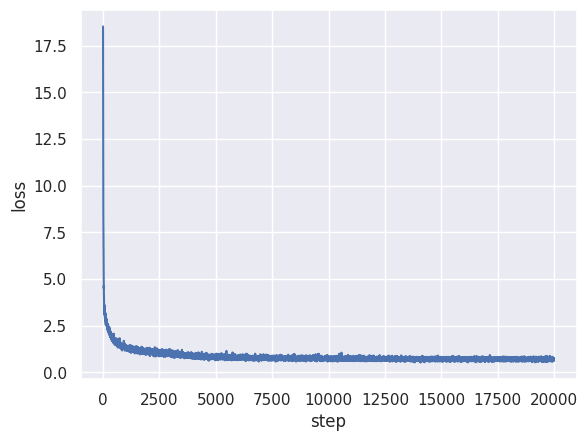

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme()

df = pd.DataFrame({
    'loss': gen_metrics['loss'],
    'step': np.arange(gen_metrics['loss'].size)
})

sns.lineplot(df, x='step', y='loss')
plt.show()

/tmp/ipykernel_3319082/1460837737.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [30]
/tmp/ipykernel_3319082/1460837737.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [30]


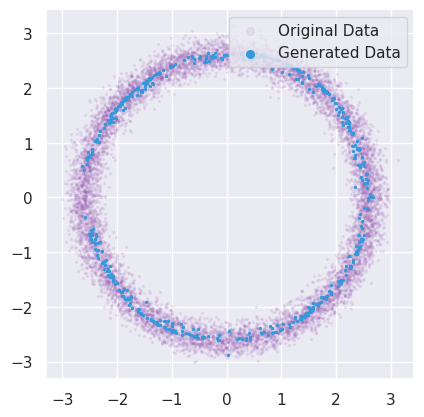

In [97]:
inputs = generator_sample(_rng, batch_size=512)
generated_x = gen_train_state.apply_fn(gen_train_state.params, inputs)

sns.set_theme()
_, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.1, c="#9b59b6", label='Original Data')
ax.scatter(generated_x[:, 0], generated_x[:, 1], s=2, alpha=1.0, c="#3498db", label='Generated Data')
lgnd = ax.legend(loc='upper right')
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

ax.set_aspect('equal', adjustable='box')
plt.show()

### Sensitivity to the weight of the PDF loss

However, this is sensitive to the weight of the PDF loss. If the weight is too high, the generator will collapse to the mode of the distribution.
If the weight is too low, the generator will stray too far from the distribution.

In [88]:
from flax.training.train_state import TrainState
import optax
import chex

latent_dim = 64
pdf_loss_weight = 0.1


def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, inputs):
        generated_x, updates = train_state.apply_fn(
            params, inputs, train=True,
            mutable=['batch_stats']
        )
        _, targets = inputs
        pdf_loss = diffusion_pdf_loss(generated_x).mean()
        target_loss = jnp.mean(jnp.linalg.norm(generated_x - targets, axis=-1))
        loss = pdf_loss_weight * pdf_loss + target_loss
        return loss, updates['batch_stats']

    rng, _rng = jax.random.split(rng)
    inputs = generator_sample(_rng)
    grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
    (loss, batch_stats), grads = grad_fn(train_state.params, inputs)
    updates, new_opt_state = train_state.tx.update(grads, train_state.opt_state)
    new_params = optax.apply_updates(train_state.params['params'], updates['params'])
    new_variables = {'params': new_params, 'batch_stats': batch_stats}
    new_train_state = train_state.replace(
        params=new_variables,
        opt_state=new_opt_state,
        step=train_state.step + 1
    )
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs = generator_sample(_rng)
generator = GeneratorModel()
init_params = generator.init(_rng, inputs)
optimizer = optax.adam(1e-3)
init_train_state = TrainState.create(
    apply_fn=generator.apply,
    params=init_params,
    tx=optimizer
)

(gen_train_state, _), gen_metrics = jax.lax.scan(
    jax.jit(update_fn), (init_train_state, rng), None, length=20000
)

/tmp/ipykernel_3319082/2629629827.py:9: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [30]
/tmp/ipykernel_3319082/2629629827.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [30]


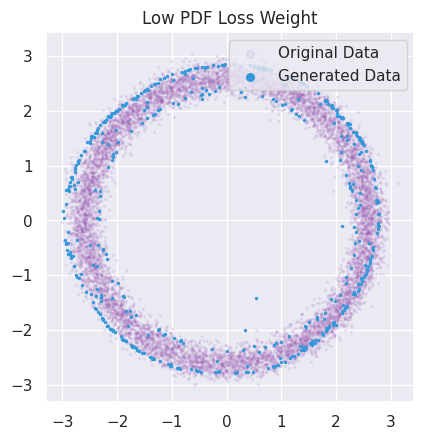

In [89]:
inputs = generator_sample(_rng, batch_size=512)
generated_x = gen_train_state.apply_fn(gen_train_state.params, inputs)

sns.set_theme()
_, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.1, c="#9b59b6", label='Original Data')
ax.scatter(generated_x[:, 0], generated_x[:, 1], s=2, alpha=1.0, c="#3498db", label='Generated Data')
lgnd = ax.legend(loc='upper right')
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

ax.set_aspect('equal', adjustable='box')
ax.set_title('Low PDF Loss Weight')
plt.show()

/tmp/ipykernel_3319082/50365402.py:64: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [30]
/tmp/ipykernel_3319082/50365402.py:65: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [30]


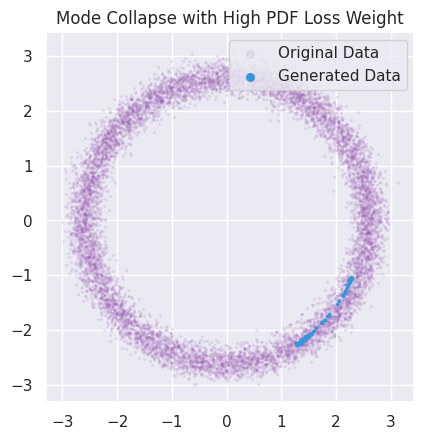

In [87]:
from flax.training.train_state import TrainState
import optax
import chex


latent_dim = 64
pdf_loss_weight = 10.0


def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, inputs):
        generated_x, updates = train_state.apply_fn(
            params, inputs, train=True,
            mutable=['batch_stats']
        )
        _, targets = inputs
        pdf_loss = diffusion_pdf_loss(generated_x).mean()
        target_loss = jnp.mean(jnp.linalg.norm(generated_x - targets, axis=-1))
        loss = pdf_loss_weight * pdf_loss + target_loss
        return loss, updates['batch_stats']

    rng, _rng = jax.random.split(rng)
    inputs = generator_sample(_rng)
    grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
    (loss, batch_stats), grads = grad_fn(train_state.params, inputs)
    updates, new_opt_state = train_state.tx.update(grads, train_state.opt_state)
    new_params = optax.apply_updates(train_state.params['params'], updates['params'])
    new_variables = {'params': new_params, 'batch_stats': batch_stats}
    new_train_state = train_state.replace(
        params=new_variables,
        opt_state=new_opt_state,
        step=train_state.step + 1
    )
    metrics = {'loss': loss}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs = generator_sample(_rng)
generator = GeneratorModel()
init_params = generator.init(_rng, inputs)
optimizer = optax.adam(1e-3)
init_train_state = TrainState.create(
    apply_fn=generator.apply,
    params=init_params,
    tx=optimizer
)

(gen_train_state, _), gen_metrics = jax.lax.scan(
    jax.jit(update_fn), (init_train_state, rng), None, length=20000
)

inputs = generator_sample(_rng, batch_size=512)
generated_x = gen_train_state.apply_fn(gen_train_state.params, inputs)

sns.set_theme()
_, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=2, alpha=0.1, c="#9b59b6", label='Original Data')
ax.scatter(generated_x[:, 0], generated_x[:, 1], s=2, alpha=1.0, c="#3498db", label='Generated Data')
lgnd = ax.legend(loc='upper right')
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

ax.set_aspect('equal', adjustable='box')
ax.set_title('Mode Collapse with High PDF Loss Weight')
plt.show()